In [1]:
import numpy as np
from numpy import concatenate
import pandas as pd
from math import sqrt
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

In [2]:
dff = pd.read_csv("data/export_data_all.csv")
df = dff.copy()
df.head()

,Export,Import,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2
0,Iceland,China,2000,11191.652,5022.337,8.982048e+09,1.093997e+12,32381.625236,873.287062,7861.07,0,1
1,Iceland,France,2000,87202.089,104187.632,8.982048e+09,1.492648e+12,32381.625236,24673.203048,2372.32,0,1
2,Iceland,Germany,2000,312116.389,262963.856,8.982048e+09,2.194204e+12,32381.625236,26725.915218,2246.80,0,1
3,Iceland,Italy,2000,27966.976,34470.260,8.982048e+09,1.252024e+12,32381.625236,21997.624316,3138.62,0,1
4,Iceland,Netherlands,2000,147015.380,120782.848,8.982048e+09,4.468986e+11,32381.625236,28263.096711,1932.09,0,1


From the year column is substracted 2000 to work with smaller values. Additionally, "Export" and "Import" columns are dropped, since they will not used in the model.

In [3]:
df["Year"] = df["Year"]-2000
df.drop(["Export","Import"],axis=1,inplace=True)

Since the variables has different ranges of values, scaling is needed to get an efficient result. Due to dealing with economic data, natural logarithm is taken of the columns in the 'columns' list to normalized.

In [4]:
columns = ['Export_Value', 'Export_Value_(t-1)', 'GDP_i(t-1)', 'GDP_j(t-1)','GDPPC_i(t-1)', 'GDPPC_j(t-1)', 'D_ij']
df[columns] = df[columns].apply(lambda x: np.log(x))

In [5]:
df.head()

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2
0,0,9.322923,8.521651,22.918494,27.720859,10.385346,6.772264,8.969678,0,1
1,0,11.375984,11.553949,22.918494,28.031573,10.385346,10.113473,7.771624,0,1
2,0,12.651131,12.479772,22.918494,28.416841,10.385346,10.193389,7.717262,0,1
3,0,10.238780,10.447852,22.918494,27.855782,10.385346,9.998690,8.051538,0,1
4,0,11.898292,11.701750,22.918494,26.825597,10.385346,10.249312,7.566358,0,1


After taken natural logarithm of the columns, min-max normalization is appilied to obtain smalled numbers. Fit_transform() is a combination of fit and transform method. Fit method computes the mean and standard deviation of the feature and transform method applies these calculations to every data point for each feature. Since only target value, Export_Value, is needed to calculate the error after the model prediction, MinMaxScaler() is applied to target value and features separately for normalization which is scaling each data point with Equation **???**:

In [6]:
min_max_scaler_y = preprocessing.MinMaxScaler()
df['Export_Value']= min_max_scaler_y.fit_transform(pd.DataFrame(df['Export_Value']))
                                                           #İki boyutlu istediği için data frame çevirip atadık.     
columns_mms=['Export_Value_(t-1)', 'GDP_i(t-1)', 'GDP_j(t-1)','GDPPC_i(t-1)', 'GDPPC_j(t-1)', 'D_ij']
min_max_scaler_x = preprocessing.MinMaxScaler()
df[columns_mms] = min_max_scaler_x.fit_transform(df[columns_mms])

In [7]:
df.head()

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2
0,0,0.239215,0.166455,0.018261,0.624801,0.668563,0.000000,0.915914,0,1
1,0,0.426011,0.442586,0.018261,0.664507,0.668563,0.700554,0.522239,0,1
2,0,0.542030,0.526894,0.018261,0.713741,0.668563,0.717310,0.504376,0,1
3,0,0.322544,0.341861,0.018261,0.642043,0.668563,0.676487,0.614218,0,1
4,0,0.473533,0.456045,0.018261,0.510394,0.668563,0.729036,0.454790,0,1


The dataset is divided into target value and features for model.

In [8]:
y_values = df['Export_Value'].values
x_values = df.drop('Export_Value',axis=1).values

The dataset is splited into training, validation, and testing. As the dataset is a time series, the order of the dataset is important. The training, validation, and test dataseta has rows from 2000 to 2016, from 2017 to 2018, and 2019, respectively.

In [9]:
train_row = 748 # 2000-2016
val = 836 # 2017-2018

train_X = x_values[:train_row, :]
validation_X = x_values[train_row:val, :]
test_X = x_values[val:, :]

train_y = y_values[:train_row]
validation_y = y_values[train_row:val]
test_y = y_values[val:]

LSTM takes input layer in three dimension as samples, time steps, and features. So, x and y values are reshaped from 2-dimension to 3-dimension. Time step represents how many rows the model will go back while learning. If time step takes the value 1, it implies that it will look at only current row. For instance, if the time step is 3, the model will look from current row to two previous row to learn.  

Time steps is taken value 1 because higher error value is received when changing the timestep with higher value than 1. Since country pairs repeat every 44 rows, especially the value of 44 has been considered for timestep value. However, as stated before, value 44 did not give as good results as value 1. When tested with value 1, obtained error values were between 0.4 and 0.6, but while tested with 44, obtained error values were bigger than 1. Moreover, since the previous year's data is taken as features while preparing the data, LSTM already estimates the export value based on the previous year's data when it only looks at the current row.

In [10]:
timesteps = 1

train_X = train_X.reshape((train_X.shape[0]//timesteps, timesteps, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0]//timesteps, timesteps, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0]//timesteps, timesteps, test_X.shape[1]))

train_y = train_y.reshape((train_y.shape[0]//timesteps, timesteps,))
validation_y = validation_y.reshape((validation_y.shape[0]//timesteps, timesteps,))
test_y =  test_y.reshape((test_y.shape[0]//timesteps, timesteps,))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(748, 1, 9) (748, 1) (88, 1, 9) (88, 1) (44, 1, 9) (44, 1)


There is a function called Sequential() to build models layer by layer in Keras. Each layer is followed by the next layer with its corresponding weights. The add function is used for adding layers to the model.[kaynakk](https://medium.com/ai-techsystems/mushroom-classification-using-deep-learning-e0154afa4c03)  

On the first hidden layer, LSTMs input layer should be defined with input_shape argument. Two values are required for the input shape argument: the number of time steps and the number of features. LSTM presumes that sample number is 1 or more.[kaynakk](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)  

Dense class is applied for connecting layers. In the first argument of the Dense class, the number of neurons in the output layer is defined.

In [11]:
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

The loss function is needed to be specified for evaluating weights according to it. The optimizer adam whis is some sort of Stochastic Gradient Descent (SGD) is used for computation of the gradient and it will update the weights on small batches.

In [12]:
model.compile(loss='mse', optimizer='adam')

While training the model, the number of epochs to apply is a crucial issue. If the number of epochs is high, the developed model may be over-fitting for the training dataset, while using less may result in underfitting. This problem can be avoided by applying the early stopping method. On model.fit, argument “epochs” mostly given as large numbers. The early stopping stops training of the model when it realizes the model has already learned.

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

The model has been specified and compiled; therefore, it is now ready for efficient computing.

In [14]:
history = model.fit(train_X, train_y, epochs=200, batch_size=None, validation_data=(validation_X, validation_y), verbose=2, shuffle=False, callbacks=[es])

Epoch 1/200
24/24 - 3s - loss: 0.1911 - val_loss: 0.0534 - 3s/epoch - 114ms/step
Epoch 2/200
24/24 - 0s - loss: 0.0788 - val_loss: 0.0516 - 71ms/epoch - 3ms/step
Epoch 3/200
24/24 - 0s - loss: 0.0566 - val_loss: 0.0575 - 75ms/epoch - 3ms/step
Epoch 4/200
24/24 - 0s - loss: 0.0479 - val_loss: 0.0483 - 74ms/epoch - 3ms/step
Epoch 5/200
24/24 - 0s - loss: 0.0421 - val_loss: 0.0411 - 83ms/epoch - 3ms/step
Epoch 6/200
24/24 - 0s - loss: 0.0372 - val_loss: 0.0363 - 95ms/epoch - 4ms/step
Epoch 7/200
24/24 - 0s - loss: 0.0329 - val_loss: 0.0324 - 83ms/epoch - 3ms/step
Epoch 8/200
24/24 - 0s - loss: 0.0295 - val_loss: 0.0292 - 86ms/epoch - 4ms/step
Epoch 9/200
24/24 - 0s - loss: 0.0267 - val_loss: 0.0268 - 84ms/epoch - 3ms/step
Epoch 10/200
24/24 - 0s - loss: 0.0245 - val_loss: 0.0248 - 89ms/epoch - 4ms/step
Epoch 11/200
24/24 - 0s - loss: 0.0227 - val_loss: 0.0230 - 91ms/epoch - 4ms/step
Epoch 12/200
24/24 - 0s - loss: 0.0213 - val_loss: 0.0215 - 80ms/epoch - 3ms/step
Epoch 13/200
24/24 - 0s -

Epoch 101/200
24/24 - 0s - loss: 9.7169e-04 - val_loss: 0.0020 - 78ms/epoch - 3ms/step
Epoch 102/200
24/24 - 0s - loss: 9.6613e-04 - val_loss: 0.0020 - 77ms/epoch - 3ms/step
Epoch 103/200
24/24 - 0s - loss: 9.6097e-04 - val_loss: 0.0020 - 70ms/epoch - 3ms/step
Epoch 104/200
24/24 - 0s - loss: 9.5621e-04 - val_loss: 0.0020 - 75ms/epoch - 3ms/step
Epoch 105/200
24/24 - 0s - loss: 9.5186e-04 - val_loss: 0.0020 - 72ms/epoch - 3ms/step
Epoch 106/200
24/24 - 0s - loss: 9.4793e-04 - val_loss: 0.0020 - 79ms/epoch - 3ms/step
Epoch 107/200
24/24 - 0s - loss: 9.4441e-04 - val_loss: 0.0020 - 66ms/epoch - 3ms/step
Epoch 108/200
24/24 - 0s - loss: 9.4132e-04 - val_loss: 0.0020 - 71ms/epoch - 3ms/step
Epoch 109/200
24/24 - 0s - loss: 9.3865e-04 - val_loss: 0.0020 - 62ms/epoch - 3ms/step
Epoch 110/200
24/24 - 0s - loss: 9.3641e-04 - val_loss: 0.0020 - 65ms/epoch - 3ms/step
Epoch 111/200
24/24 - 0s - loss: 9.3461e-04 - val_loss: 0.0020 - 67ms/epoch - 3ms/step
Epoch 112/200
24/24 - 0s - loss: 9.3325e-04

Y axis shows loss which is the mean squared error value while x axis showing epochs. Figure 4 shows comparison of training data and validation data. It shows decrease in the loss by epochs.

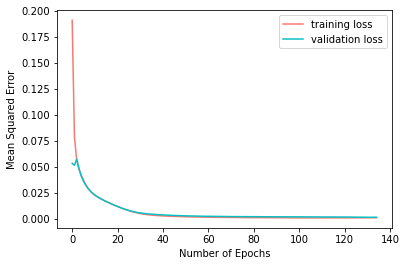

In [15]:
pyplot.plot(history.history['loss'], label='training loss', color='#f87970')
pyplot.plot(history.history['val_loss'], label='validation loss', color='#06c0c5')
pyplot.legend()
pyplot.xlabel("Number of Epochs")
pyplot.ylabel("Mean Squared Error")
pyplot.show()

LSTM model makes prediction with help of predict function in the Keras library. Since the model takes scaled values, it also makes the estimation in this value range. Therefore, back scaling is needed to obtain true value. But, because of dealing with economic data, only the inverse transformation of min-max scaling is taken. Thus, in this case, values are still logarithmed. After taken back scaling of prediction and tesy_y values, root of the mean squared error is calculate value 0.59 as shown Figure **???**.

In [16]:
yhat = model.predict(test_X)

inv_yhat = min_max_scaler_y.inverse_transform(yhat) 
test_y = test_y.reshape((len(test_y)*timesteps, 1))
inv_y = min_max_scaler_y.inverse_transform(test_y)

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.412


In [17]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
inv_yhat_y = pd.concat((inv_yhat, inv_y),axis=1)
inv_yhat_y.columns = ["Prediction","2019_Values"]
countries_df = dff[["Export","Import"]].iloc[:44]
prediction_data = pd.concat((countries_df, inv_yhat_y),axis=1)
prediction_data

,Export,Import,Prediction,2019_Values
0,Iceland,China,12.189871,11.773858
1,Iceland,France,13.117925,12.821405
2,Iceland,Germany,13.157817,12.642021
3,Iceland,Italy,11.503823,10.430927
4,Iceland,Netherlands,14.166690,14.133159
5,Iceland,Norway,12.668027,12.215879
6,Iceland,Spain,13.086917,13.113035
7,Iceland,Switzerland,11.157891,9.765879
8,Iceland,Turkey,10.393670,9.908276
9,Iceland,United Kingdom,13.622928,13.206026
